# Lecture 4: ML workflow (Terminology, Baselines, Decision Trees)

MTU Spring 2024

Instructor: Abel Reyes

## Imports, Announcements, LOs

## imports

In [43]:
# import the libraries
import os
import sys

import graphviz
import IPython
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import HTML
from sklearn.model_selection import train_test_split

sys.path.append("code/.")
from plotting_functions import *

# Classifiers
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from utils import *

%matplotlib inline

pd.set_option("display.max_colwidth", 200)

### Announcements

- hw1 released. (Due this week Wednesday at 11:59pm.) 
    - Group submissions are not allowed for this assignment. 
    - Usually the deadlines will be on Wednesday
- Advice on keeping up with the material 
    - Practice! 
    - Make sure you run the lecture notebooks on your laptop. 
    - Start early on homework assignments.     
- Quiz I will be this FRIDAY! (take home quiz, 15 mins)
- HW2 will be released this Wednesday (01/24/24)
- Group formation Google Sheet is available for edition until this Friday (01/26/2024)

### Learning outcomes

From this lecture, you will be able to 

- explain how decision boundaries change with the `max_depth` hyperparameter;
- explain the concept of generalization;
- appropriately split a dataset into train and test sets using `train_test_split` function;
- explain the difference between train, validation, test, and "deployment" data;
- identify the difference between training error, validation error, and test error;
- explain cross-validation and use `cross_val_score` and `cross_validate` to calculate cross-validation error;
- recognize overfitting and/or underfitting by looking at train and test scores;
- explain why it is generally not possible to get a perfect test score (zero test error) on a supervised learning problem;
- describe the fundamental tradeoff between training score and the train-test gap;
- state the golden rule;
- start to build a standard recipe for supervised learning: train/test split, hyperparameter tuning with cross-validation, test on test set.

## Data acquisition

In [2]:
# Toy quiz2 grade data
classification_df = pd.read_csv("data/quiz2-grade-toy-classification.csv")
classification_df.head(10)

,ml_experience,class_attendance,lab1,lab2,lab3,lab4,quiz1,quiz2
0,1,1,92,93,84,91,92,A+
1,1,0,94,90,80,83,91,not A+
2,0,0,78,85,83,80,80,not A+
3,0,1,91,94,92,91,89,A+
4,0,1,77,83,90,92,85,A+
5,1,0,70,73,68,74,71,not A+
6,1,0,80,88,89,88,91,A+
7,0,1,95,93,69,79,75,not A+
8,0,0,97,90,94,99,80,not A+
9,1,1,95,95,94,94,85,not A+


In [3]:
## ISIC dataset
## https://challenge.isic-archive.com/data/

from PIL import Image
import glob
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os


In [4]:
tr_folder="data/ISBI2016_ISIC_Part3B_Training_Data"
ts_folder="data/ISBI2016_ISIC_Part3B_Test_Data"
size=128

In [5]:
image_list=[] ## Initialize an empty list
for filename in glob.glob(f"{tr_folder}\*.jpg"):
    im=Image.open(filename) ## Open the image file
    im=im.resize((size,size)) ## Resize the image if needed
    im_arr=np.array(im) ## Image object to array object
    im_arr=im_arr/255. ## Normalize the image
    image_list.append(im_arr) ## Add the image to the list
images_arr=np.array(image_list) ## List to array

In [6]:
images_arr.shape

(900, 128, 128, 3)

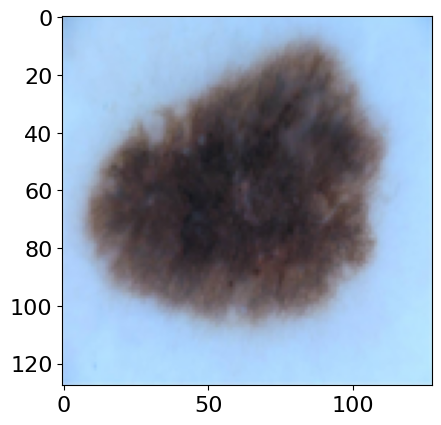

In [7]:
plt.imshow(images_arr[0])

In [8]:
masks_list=[]
for filename in glob.glob(f"{tr_folder}\*.png"):
    im=Image.open(filename)
    im=im.resize((size,size))
    im_arr=np.array(im)
    im_arr=im_arr/255.
    masks_list.append(im_arr)
    
masks_arr=np.array(masks_list)
masks_arr=np.expand_dims(masks_arr, axis=-1)

In [9]:
masks_arr.shape

(900, 128, 128, 1)

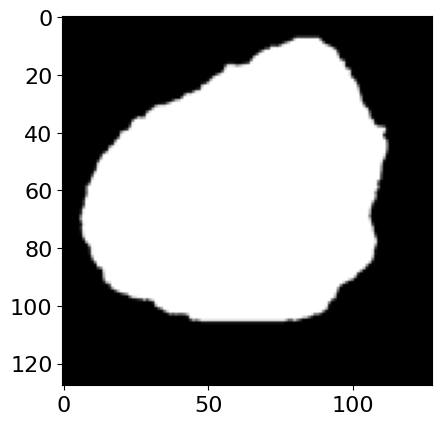

In [10]:
plt.imshow(masks_arr[0], 'gray')

In [11]:
print(images_arr.shape)
print(masks_arr.shape)

(900, 128, 128, 3)
(900, 128, 128, 1)


## Generalization

### Big picture and motivation 

In machine learning we want to learn a mapping function from labeled data so that we can predict labels of **unlabeled** data. For example, suppose we want to build a spam filtering system.  We will take a large number of spam/non-spam messages from the past, learn patterns associated with spam/non-spam from them, and predict whether **a new incoming message** in someone's inbox is spam or non-spam based on these patterns. 

So we want to learn from the past but ultimately we want to apply it on the future email messages. 

**How can we generalize from what we've seen to what we haven't seen?** 

In this lecture, we'll see how machine learning tackles this question. 

### Model complexity and training error

In the last lecture, we looked at decision boundaries, a way to visualize what sort of examples will be classified as positive and negative. 

Let's examine how does the decision boundary change for different tree depths. 

In [12]:
# Toy quiz2 grade data
classification_df = pd.read_csv("data/quiz2-grade-toy-classification.csv")
classification_df.head(10)

,ml_experience,class_attendance,lab1,lab2,lab3,lab4,quiz1,quiz2
0,1,1,92,93,84,91,92,A+
1,1,0,94,90,80,83,91,not A+
2,0,0,78,85,83,80,80,not A+
3,0,1,91,94,92,91,89,A+
4,0,1,77,83,90,92,85,A+
5,1,0,70,73,68,74,71,not A+
6,1,0,80,88,89,88,91,A+
7,0,1,95,93,69,79,75,not A+
8,0,0,97,90,94,99,80,not A+
9,1,1,95,95,94,94,85,not A+


In [13]:
X = classification_df.drop(["quiz2"], axis=1)
y = classification_df["quiz2"]

In [14]:
X_subset = X[["lab4", "quiz1"]]  # Let's consider a subset of the data for visualization
X_subset.head()

,lab4,quiz1
0,91,92
1,83,91
2,80,80
3,91,89
4,92,85


In the following model, this decision boundary is created by asking one question. 

Error:   0.286


C:\Users\sanjay\anaconda3\envs\pytorch_cuda\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


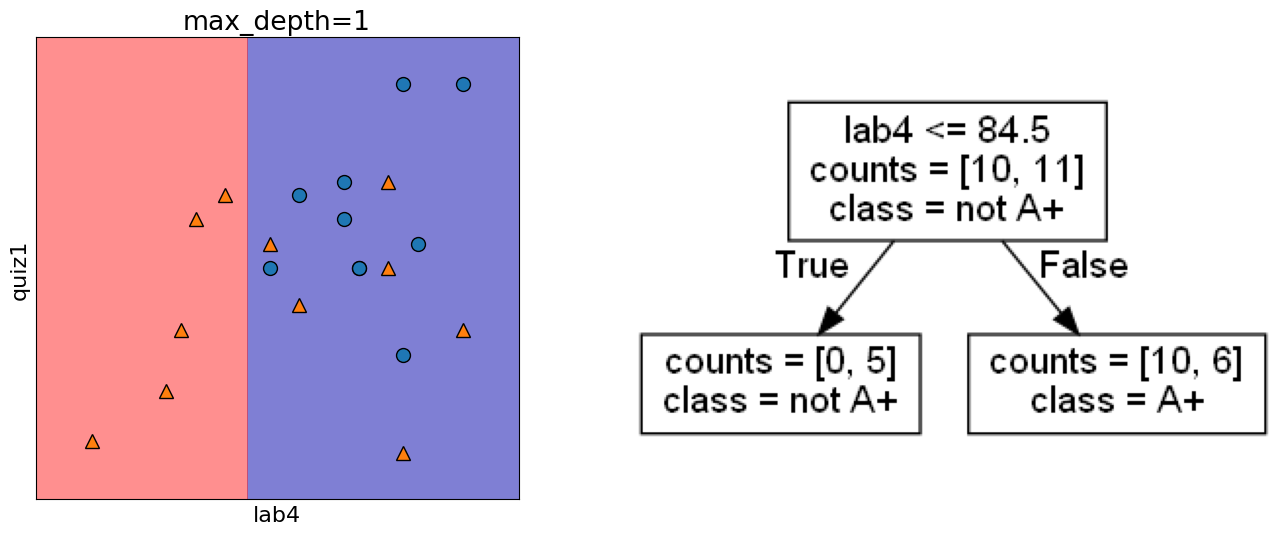

In [15]:
depth = 1
model = DecisionTreeClassifier(max_depth=depth)
model.fit(X_subset, y)
model.score(X_subset, y)
print("Error:   %0.3f" % (1 - model.score(X_subset, y)))
plot_tree_decision_boundary_and_tree(
    model, X_subset, y, x_label="lab4", y_label="quiz1"
)

In the following model, this decision boundary is created by asking two questions. 

Error:   0.190


C:\Users\sanjay\anaconda3\envs\pytorch_cuda\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


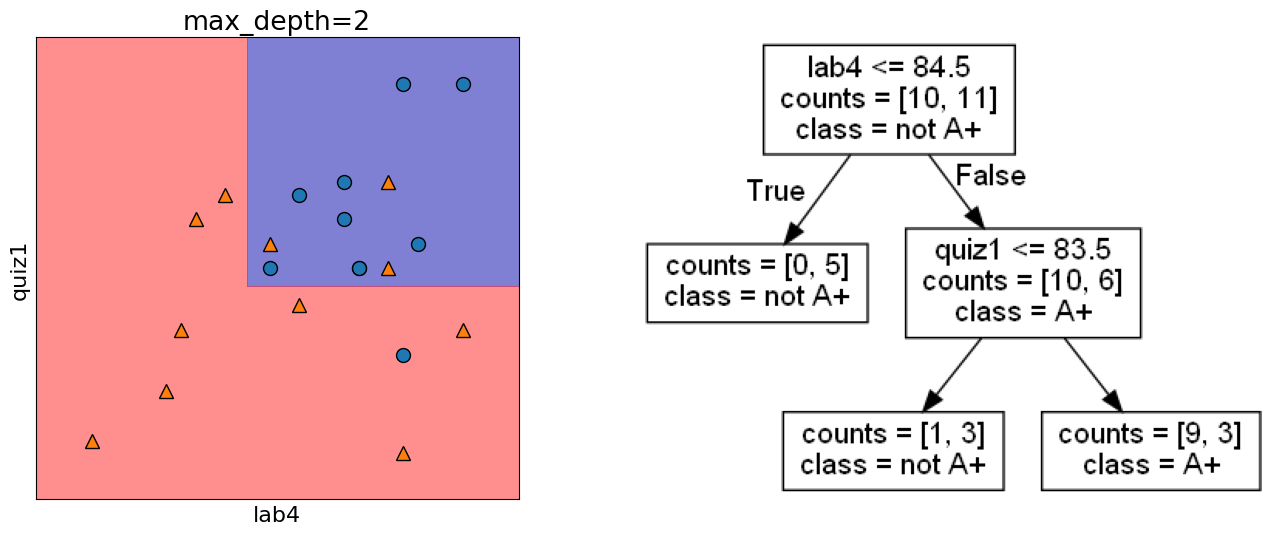

In [16]:
depth = 2
model = DecisionTreeClassifier(max_depth=depth)
model.fit(X_subset, y)
model.score(X_subset, y)
print("Error:   %0.3f" % (1 - model.score(X_subset, y)))
plot_tree_decision_boundary_and_tree(
    model, X_subset, y, x_label="lab4", y_label="quiz1"
)

Let's look at the decision boundary with depth = 4. 

Error:   0.048


C:\Users\sanjay\anaconda3\envs\pytorch_cuda\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


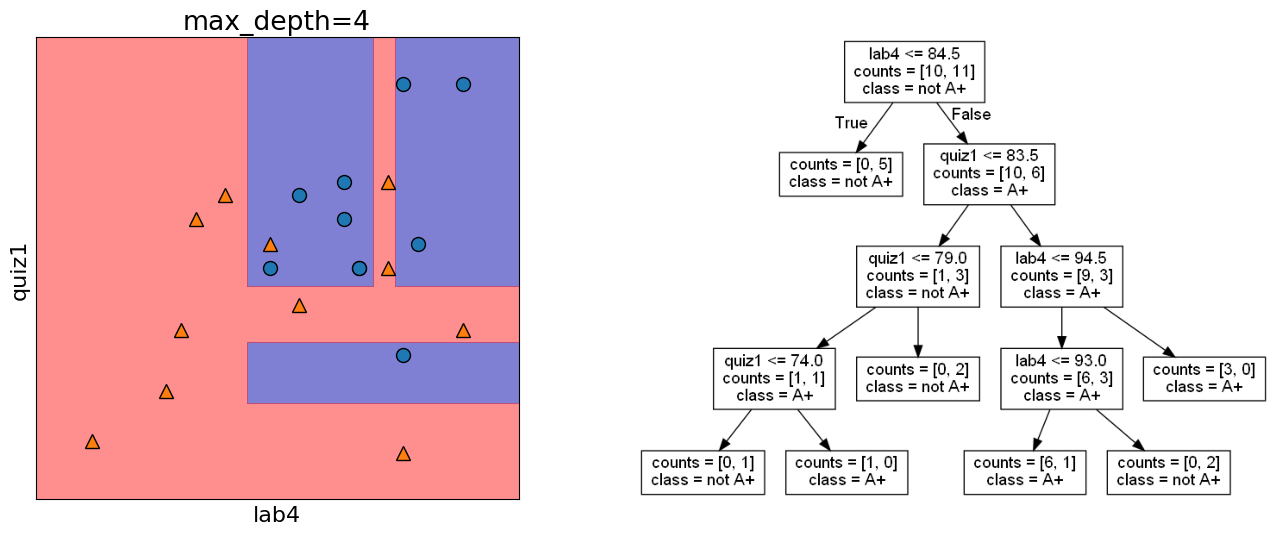

In [17]:
depth = 4
model = DecisionTreeClassifier(max_depth=depth)
model.fit(X_subset, y)
model.score(X_subset, y)
print("Error:   %0.3f" % (1 - model.score(X_subset, y)))
plot_tree_decision_boundary_and_tree(
    model, X_subset, y, x_label="lab4", y_label="quiz1"
)

Let's look at the decision boundary with depth = 6. 

Error:   0.000


C:\Users\sanjay\anaconda3\envs\pytorch_cuda\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


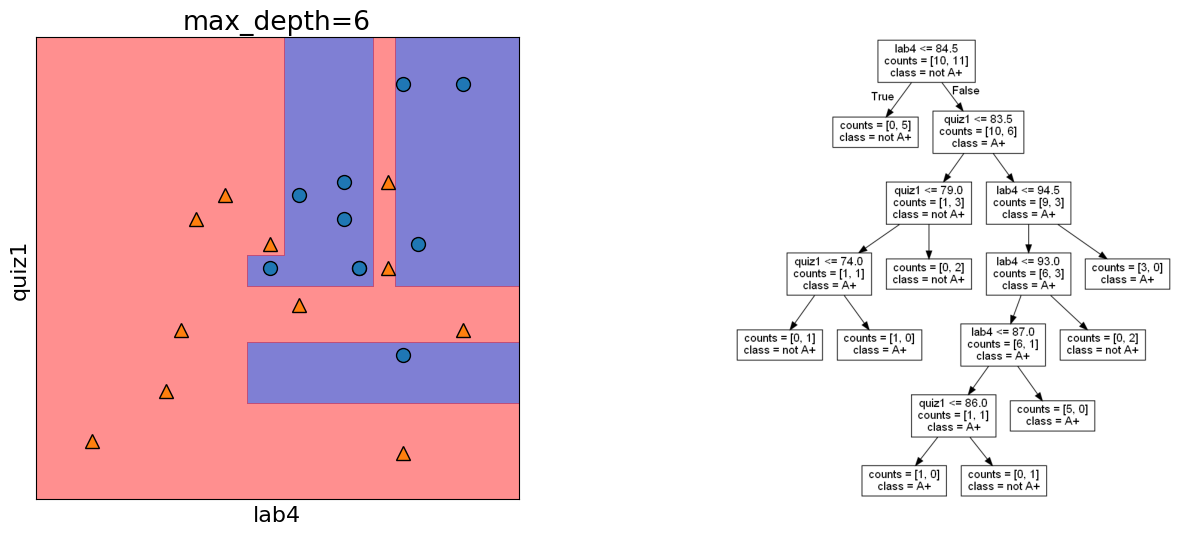

In [18]:
depth = 6
model = DecisionTreeClassifier(max_depth=depth)
model.fit(X_subset, y)
model.score(X_subset, y)
print("Error:   %0.3f" % (1 - model.score(X_subset, y)))
plot_tree_decision_boundary_and_tree(
    model, X_subset, y, x_label="lab4", y_label="quiz1"
)

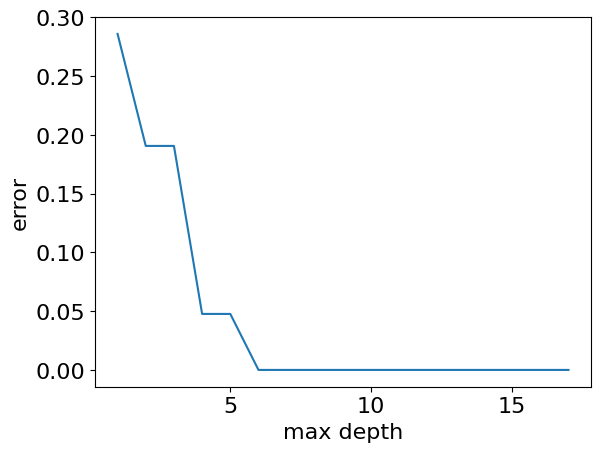

In [19]:
max_depths = np.arange(1, 18)
errors = []
for max_depth in max_depths:
    error = 1 - DecisionTreeClassifier(max_depth=max_depth).fit(X_subset, y).score(
        X_subset, y
    )
    errors.append(error)
plt.plot(max_depths, errors)
plt.xlabel("max depth")
plt.ylabel("error");

- Our model has 0% error for depths >= 6!! 
- But it's also becoming more and more specific and sensitive to the training data.  
- Is it good or bad?

```{admonition} Note 
:class: note
Although the plot above (complexity hyperparameter vs error) is more popular, we could also look at the same plot flip the $y$-axis, i.e., consider accuracy instead of error. 
```

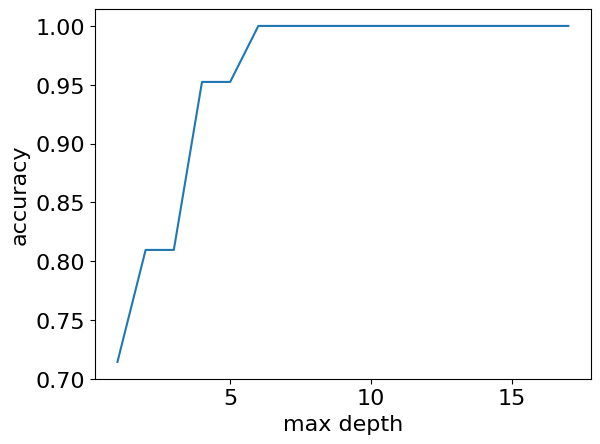

In [20]:
max_depths = np.arange(1, 18)
accuracies = []
for max_depth in max_depths:
    accuracy = (
        DecisionTreeClassifier(max_depth=max_depth).fit(X_subset, y).score(X_subset, y)
    )
    accuracies.append(accuracy)
plt.plot(max_depths, accuracies)
plt.xlabel("max depth")
plt.ylabel("accuracy");

- How to pick the best depth? 
- How can we make sure that the model we have built would do reasonably well on new data in the wild when it's deployed? 
- Which of the following rules learned by the decision tree algorithm are likely to generalize better to new data? 

> Rule 1: If class_attendance == 1 then grade is A+. 

> Rule 2: If lab3 > 83.5 and quiz1 <= 83.5 and lab2 <= 88 then quiz2 grade is A+

To better understand the material in the next sections, think about these questions on your own or discuss them with your classmates

### Generalization: Fundamental goal of ML

> **To generalize beyond what we see in the training examples**

We only have access to limited amount of training data and we want to learn a mapping function which would predict targets reasonably well for examples beyond this training data. 

- Example: Imagine that a learner sees the following images and corresponding labels. 

![](img/generalization-train.png)
<!-- <center>
<img src='img/generalization-train.png' width="600" height="600" />
</center>     -->

### Generalizing to unseen data

- Now the learner is presented with new images (1 to 4) for prediction. 
- What prediction would you expect for each image?   

![](img/generalization-predict.png)

<!-- <center>
<img src='img/generalization-predict.png' width="1000" height="1000" />
</center>     -->

- Goal: We want the learner to be able to generalize beyond what it has seen in the training data.
- But these new examples should be representative of the training data. That is they should have the same characteristics as the training data. 
- In this example, we would like the leaner to be able to predict labels for test examples 1, 2, and 3 accurately. Although 2, 3 don't exactly occur in the training data, they are very much similar to the images in the training data. That said, is it fair to expect the learner to label image 4 correctly? 

### Training error vs. Generalization error 

- Given a model $M$, in ML, people usually talk about two kinds of errors of $M$. 
    1. Error on the training data: $error_{training}(M)$ 
    2. Error on the entire distribution $D$ of data: $error_{D}(M)$
- We are interested in the error on the entire distribution     
    - ... But we do not have access to the entire distribution 😞

## 1/24/24

### Announcements
- Homework 2 is out. Please start early. 
- Homework 1 deadline is today @ midnight (make sure to submit it on time) 
- Quiz 1 on Friday!. 

## Data Splitting

### How to approximate generalization error? 

A common way is **data splitting**. 
- Keep aside some randomly selected portion from the training data.
- `fit` (train) a model on the training portion only. 
- `score` (assess) the trained model on this set aside data to get a sense of how well the model would be able to generalize.
- Pretend that the kept aside data is representative of the real distribution $D$ of data. 

### scikit-learn train_test_split


In [52]:
url = "https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html"
HTML("<iframe src=%s width=1000 height=800></iframe>" % url)

C:\Users\sanjay\anaconda3\envs\pytorch_cuda\lib\site-packages\IPython\core\display.py:431: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


- We can pass `X` and `y` or a dataframe with both `X` and `y` in it. 
- We can also specify the train or test split sizes. 

### Simple train/test split 

- The picture shows an 80%-20% split of a toy dataset with 10 examples. 
- The data is shuffled before splitting. 
- Usually when we do machine learning we split the data before doing anything and put the test data in an imaginary chest lock. 

![](img/train-test-split.png)

<!-- <img src='img/train-test-split.png' width="1500" height="1500" /> -->

In [44]:
df = pd.read_csv("data/canada_usa_cities.csv")
df

,longitude,latitude,country
0,-130.0437,55.9773,USA
1,-134.4197,58.3019,USA
2,-123.0780,48.9854,USA
3,-122.7436,48.9881,USA
4,-122.2691,48.9951,USA
...,...,...,...
204,-72.7218,45.3990,Canada
205,-66.6458,45.9664,Canada
206,-79.2506,42.9931,Canada
207,-72.9406,45.6275,Canada


In [45]:
# Let's demonstrate this with the canada usa cities data
# The data is available in the data directory

X = df.drop(columns=["country"])
y = df["country"]

In [46]:
X

,longitude,latitude
0,-130.0437,55.9773
1,-134.4197,58.3019
2,-123.0780,48.9854
3,-122.7436,48.9881
4,-122.2691,48.9951
...,...,...
204,-72.7218,45.3990
205,-66.6458,45.9664
206,-79.2506,42.9931
207,-72.9406,45.6275


In [23]:
y

0         USA
1         USA
2         USA
3         USA
4         USA
        ...  
204    Canada
205    Canada
206    Canada
207    Canada
208    Canada
Name: country, Length: 209, dtype: object

In [47]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=123
)  # 80%-20% train test split on X and y

# Print shapes
shape_dict = {
    "Data portion": ["X", "y", "X_train", "y_train", "X_test", "y_test"],
    "Shape": [
        X.shape,
        y.shape,
        X_train.shape,
        y_train.shape,
        X_test.shape,
        y_test.shape,
    ],
}

shape_df = pd.DataFrame(shape_dict)
HTML(shape_df.to_html(index=False))

Data portion,Shape
X,"(209, 2)"
y,"(209,)"
X_train,"(167, 2)"
y_train,"(167,)"
X_test,"(42, 2)"
y_test,"(42,)"


In [48]:
y_test

172    Canada
175    Canada
181    Canada
132    Canada
189    Canada
195    Canada
198    Canada
170    Canada
95     Canada
31        USA
42        USA
179    Canada
191    Canada
120    Canada
19        USA
72        USA
20        USA
52        USA
147    Canada
166    Canada
119    Canada
200    Canada
4         USA
108    Canada
157    Canada
21        USA
91     Canada
158    Canada
137    Canada
194    Canada
197    Canada
53        USA
180    Canada
162    Canada
184    Canada
161    Canada
10        USA
71        USA
80        USA
26        USA
11        USA
173    Canada
Name: country, dtype: object

#### Creating `train_df` and `test_df`

- Sometimes we want to keep the target in the train split for EDA or for visualization. 

In [25]:
train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=123
)  # 80%-20% train test split on df
X_train, y_train = train_df.drop(columns=["country"]), train_df["country"]
X_test, y_test = test_df.drop(columns=["country"]), test_df["country"]
train_df.head()

,longitude,latitude,country
160,-76.4813,44.2307,Canada
127,-81.2496,42.9837,Canada
169,-66.0580,45.2788,Canada
188,-73.2533,45.3057,Canada
187,-67.9245,47.1652,Canada


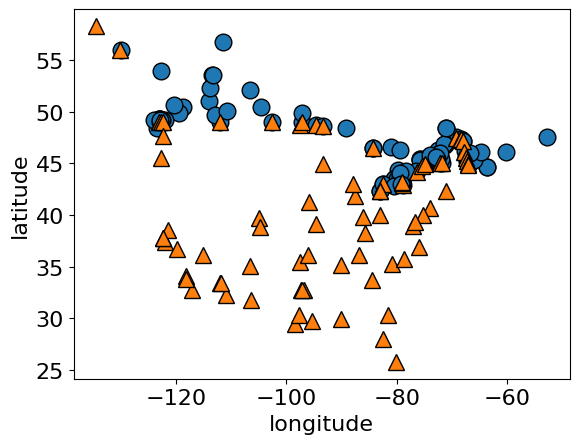

In [26]:
mglearn.discrete_scatter(X.iloc[:, 0], X.iloc[:, 1], y, s=12)
plt.xlabel("longitude")
plt.ylabel("latitude");

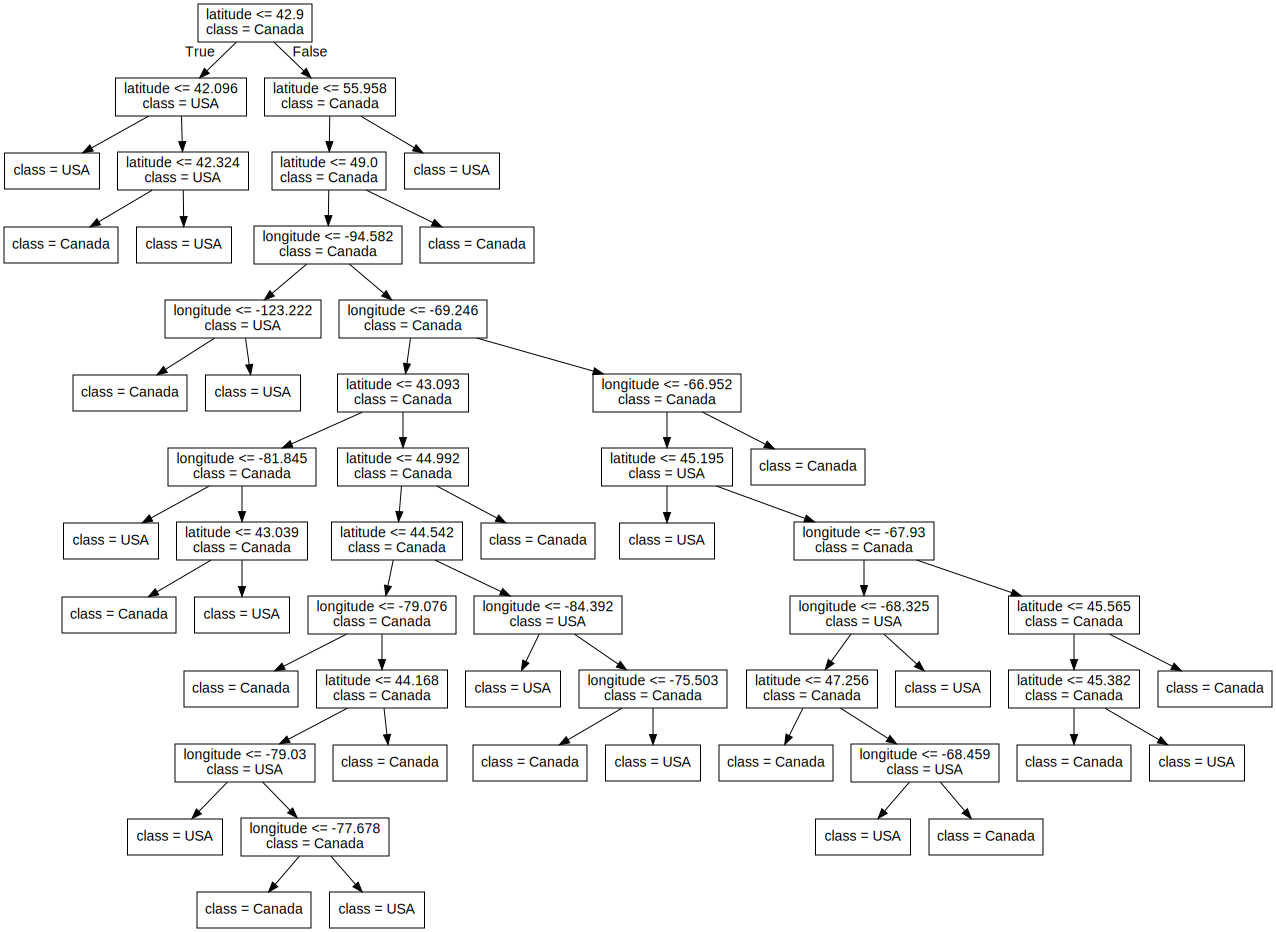

In [49]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
display_tree(X_train.columns, model)

Let's examine the train and test accuracies with the split now.

In [50]:
print("Train accuracy:   %0.3f" % model.score(X_train, y_train))
print("Test accuracy:   %0.3f" % model.score(X_test, y_test))

Train accuracy:   1.000
Test accuracy:   0.738


In [51]:
model = DecisionTreeClassifier(max_depth=1)
model.fit(X_train, y_train)
#display_tree(X_train.columns, model)
print("Train accuracy:   %0.3f" % model.score(X_train, y_train))
print("Test accuracy:   %0.3f" % model.score(X_test, y_test))

Train accuracy:   0.832
Test accuracy:   0.810


In [35]:
model = DecisionTreeClassifier(max_depth=3)
model.fit(X_train, y_train)
#display_tree(X_train.columns, model)
print("Train accuracy:   %0.3f" % model.score(X_train, y_train))
print("Test accuracy:   %0.3f" % model.score(X_test, y_test))

Train accuracy:   0.856
Test accuracy:   0.786


In [36]:
model = DecisionTreeClassifier(max_depth=6)
model.fit(X_train, y_train)
#display_tree(X_train.columns, model)
print("Train accuracy:   %0.3f" % model.score(X_train, y_train))
print("Test accuracy:   %0.3f" % model.score(X_test, y_test))

Train accuracy:   0.916
Test accuracy:   0.833


In [37]:
model = DecisionTreeClassifier(max_depth=9)
model.fit(X_train, y_train)
#display_tree(X_train.columns, model)
print("Train accuracy:   %0.3f" % model.score(X_train, y_train))
print("Test accuracy:   %0.3f" % model.score(X_test, y_test))

Train accuracy:   0.964
Test accuracy:   0.762


In [38]:
model = DecisionTreeClassifier(max_depth=12)
model.fit(X_train, y_train)
#display_tree(X_train.columns, model)
print("Train accuracy:   %0.3f" % model.score(X_train, y_train))
print("Test accuracy:   %0.3f" % model.score(X_test, y_test))

Train accuracy:   1.000
Test accuracy:   0.738


C:\Users\sanjay\anaconda3\envs\pytorch_cuda\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


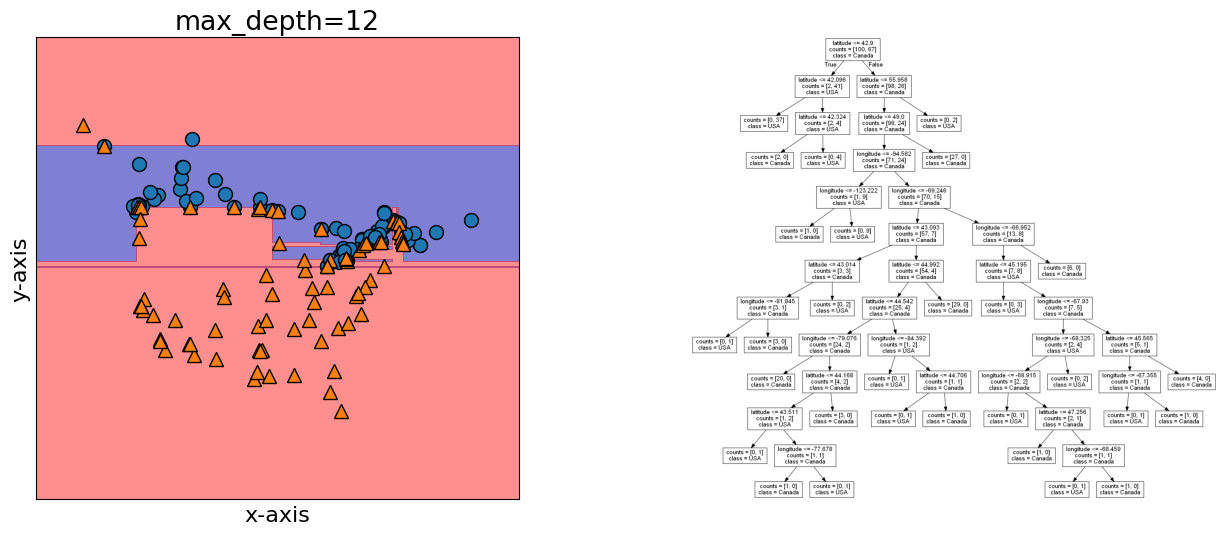

In [29]:
plot_tree_decision_boundary_and_tree(model, X, y, height=6, width=16, eps=10)

C:\Users\sanjay\anaconda3\envs\pytorch_cuda\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\sanjay\anaconda3\envs\pytorch_cuda\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


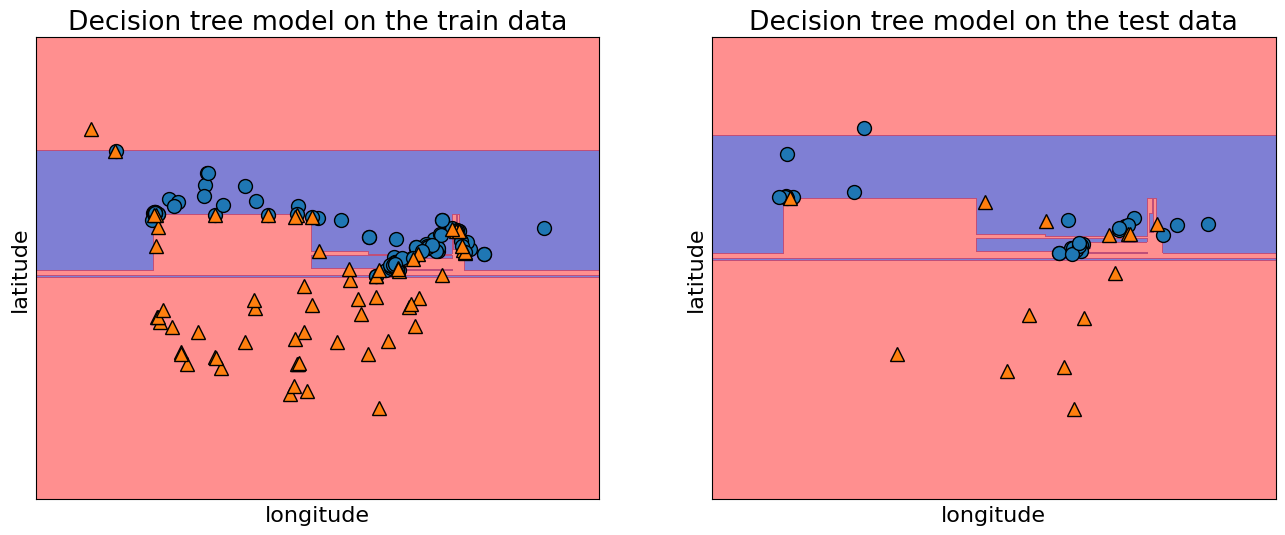

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6), subplot_kw={"xticks": (), "yticks": ()})
plot_tree_decision_boundary(
    model,
    X_train,
    y_train,
    eps=10,
    x_label="longitude",
    y_label="latitude",
    ax=ax[0],
    title="Decision tree model on the train data",
)
plot_tree_decision_boundary(
    model,
    X_test,
    y_test,
    eps=10,
    x_label="longitude",
    y_label="latitude",
    ax=ax[1],
    title="Decision tree model on the test data",
)

- Useful arguments of `train_test_split`: 
    - `test_size`
    - `train_size` 
    - `random_state`

#### `test_size`, `train_size` arguments

- Let's us specify how we want to split the data. 
- We can specify either of the two. See the documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).
- There is no hard and fast rule on what split sizes should we use. 
    - It depends upon how much data is available to you. 
- Some common splits are 90/10, 80/20, 70/30 (training/test).
- In the above example, we used 80/20 split. 

#### `random_state` argument

- The data is shuffled before splitting which is crucial step. 
- The `random_state` argument controls this shuffling. 
- In the example above we used `random_state=123`. If you run this notebook with the same `random_state` it should give you exactly the same split. 
    - Useful when you want reproducible results. 

## Stratified sampling

In [17]:
## Stratified sampling

import pandas as pd
from sklearn import datasets
 
iris = datasets.load_iris()
iris_df=pd.DataFrame(iris.data)
 
iris_df['class']=iris.target
iris_df.columns=['sepal_len', 'sepal_wid', 'petal_len', 'petal_wid', 'class']
 

X = iris_df.iloc[:,:-1]
y = iris_df.iloc[:,-1]
    
iris_df['class'].value_counts()


0    50
1    50
2    50
Name: class, dtype: int64

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(X,y, train_size=0.8, 
                                                   random_state=None, 
                                                   shuffle=True, stratify=None)
 
print("Class distribution of train set")
print(y_train.value_counts())
print()
print("Class distribution of test set")
print(y_test.value_counts())

Class distribution of train set
0    46
1    37
2    37
Name: class, dtype: int64

Class distribution of test set
2    13
1    13
0     4
Name: class, dtype: int64


In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(X,y, train_size=0.8, 
                                                   random_state=None,
                                                   shuffle=True, stratify=y)
print(y_train.value_counts())
print(y_test.value_counts())

0    40
2    40
1    40
Name: class, dtype: int64
0    10
2    10
1    10
Name: class, dtype: int64


### Train/validation/test split

- Some of you may have heard of "validation" data.
- Sometimes it's a good idea to have a separate data for hyperparameter tuning. 

![](img/train-valid-test-split.png)

<!-- <img src='img/train-valid-test-split.png' width="1500" height="1500" /> -->

- We will try to use "validation" to refer to data where we have access to the target values.
  - But, unlike the training data, we only use this for hyperparameter tuning and model assessment; we don't pass these into `fit`.  
- We will try to use "test" to refer to data where we have access to the target values 
  - But, unlike training and validation data, we neither use it in training nor hyperparameter optimization. 
  - We only use it **once** to evaluate the performance of the best performing model on the validation set.   
  - We lock it in a "vault" until we're ready to evaluate. 

Note that there isn't good concensus on the terminology of what is validation and what is test. 

```{admonition} Note 
:class: note
Validation data is also referred to as **development data** or **dev set** for short.  
```

### "Deployment" data

- After we build and finalize a model, we deploy it, and then the model deals with the data in the wild. 
- We will use "deployment" to refer to this data, where we do **not** have access to the target values.
- Deployment error is what we _really_ care about.
- We use validation and test errors as proxies for deployment error, and we hope they are similar.
- So, if our model does well on the validation and test data, we hope it will do well on deployment data.

### Summary of train, validation, test, and deployment data

|         | `fit` | `score` | `predict` |
|----------|-------|---------|-----------|
| Train    | ✔️      | ✔️      | ✔️         |
| Validation |      | ✔️      | ✔️         |
| Test    |       |  once   | once         |
| Deployment    |       |       | ✔️         |

You can typically expect $E_{train} < E_{validation} < E_{test} < E_{deployment}$.

**Select all of the following statements which are TRUE.**

- (A) A decision tree model with no depth is likely to perform very well on the deployment data. 
- (B) Data splitting helps us assess how well our model would generalize. 
- (C) Deployment data is used at the very end and only scored once.  
- (D) Validation data could be used for hyperparameter optimization. 
- (E) It's recommended that data be shuffled before splitting it into `train` and `test` sets.


## Cross-validation

### Problems with single train/validation split

- Only using a portion of your data for training and only a portion for validation.
- If your dataset is small you might end up with a tiny training and/or validation set.
- You might be unlucky with your splits such that they don't align well or don't well represent your test data.

![](img/train-valid-test-split.png)

<!-- <img src='img/train-valid-test-split.png' width="1500" height="1500" /> -->

### Cross-validation to the rescue!! 

- Cross-validation provides a solution to this problem. 
- Split the data into $k$ folds ($k>2$, often $k=10$). In the picture below $k=4$.
- Each "fold" gets a turn at being the validation set.
- Note that cross-validation doesn't shuffle the data; it's done in `train_test_split`.

![](img/cross-validation.png)
<!-- <img src='img/cross-validation.png' width="1500"> -->

- Each fold gives a score and we usually average our $k$ results. 
- It's better to examine the variation in the scores across folds.  
- Gives a more **robust** measure of error on unseen data.

### Cross-validation using `scikit-learn`

In [25]:
from sklearn.model_selection import cross_val_score, cross_validate

#### `cross_val_score`

In [26]:
model = DecisionTreeClassifier(max_depth=4)
cv_scores = cross_val_score(model, X_train, y_train, cv=10)
cv_scores

array([0.76470588, 0.82352941, 0.70588235, 0.94117647, 0.82352941,
       0.82352941, 0.70588235, 0.9375    , 0.9375    , 0.9375    ])

In [27]:
print(f"Average cross-validation score = {np.mean(cv_scores):.2f}")
print(f"Standard deviation of cross-validation score = {np.std(cv_scores):.2f}")

Average cross-validation score = 0.84
Standard deviation of cross-validation score = 0.09


Under the hood

- It creates `cv` folds on the data.
- In each fold, it fits the model on the training portion and scores on the validation portion. 
- The output is a list of validation scores in each fold.

#### `cross_validate`

- Similar to `cross_val_score` but more powerful.
- Gives us access to training and validation scores.  

In [28]:
scores = cross_validate(model, X_train, y_train, cv=10, return_train_score=True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.003475,0.001016,0.764706,0.913333
1,0.001943,0.001052,0.823529,0.906667
2,0.002052,0.002000,0.705882,0.906667
3,0.002002,0.002046,0.941176,0.900000
4,0.002001,0.001003,0.823529,0.906667
5,0.000928,0.002046,0.823529,0.913333
6,0.000980,0.001002,0.705882,0.920000
7,0.000999,0.001001,0.937500,0.900662
8,0.000997,0.001001,0.937500,0.900662
9,0.001004,0.000998,0.937500,0.900662


In [29]:
pd.DataFrame(pd.DataFrame(scores).mean())

,0
fit_time,0.001638
score_time,0.001316
test_score,0.840074
train_score,0.906865


```{important}
Keep in mind that cross-validation does not return a model. It is not a way to build a model that can be applied to new data. The purpose of cross-validation is to **evaluate** how well the model will generalize to unseen data. 
```

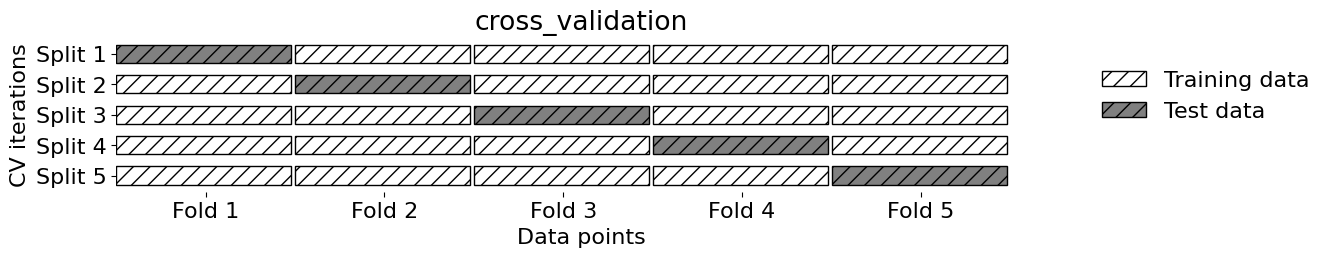

In [30]:
mglearn.plots.plot_cross_validation()

#### Our typical supervised learning set up is as follows: 

- We are given training data with features `X` and target `y`
- We split the data into train and test portions: `X_train, y_train, X_test, y_test`
- We carry out hyperparameter optimization using cross-validation on the train portion: `X_train` and `y_train`. 
- We assess our best performing model on the test portion: `X_test` and `y_test`.  
- What we care about is the **test error**, which tells us how well our model can be generalized.
- If this test error is "reasonable" we deploy the model which will be used on new unseen examples.

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
model = DecisionTreeClassifier(max_depth=10)
scores = cross_validate(model, X_train, y_train, cv=10, return_train_score=True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.001999,0.000998,0.875000,1.000000
1,0.001043,0.000957,0.875000,0.992857
2,0.001999,0.001045,0.875000,1.000000
3,0.001996,0.001000,0.750000,1.000000
4,0.001995,0.001002,0.812500,1.000000
5,0.002002,0.000998,0.812500,1.000000
6,0.000999,0.001001,0.866667,0.985816
7,0.001005,0.000996,0.600000,0.992908
8,0.000998,0.001001,0.666667,1.000000
9,0.001998,0.001001,0.733333,1.000000


In [32]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation
    """
    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [33]:
results = {}
results["Decision tree"] = mean_std_cross_val_scores(
    model, X_train, y_train, return_train_score=True
)
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
Decision tree,0.002 (+/- 0.001),0.001 (+/- 0.000),0.788 (+/- 0.055),0.992 (+/- 0.014)


- How do we know whether this test score is reasonable? 

In [20]:
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
skf = StratifiedShuffleSplit(n_splits=2, train_size = .8)
X = iris_df.iloc[:,:-1]
y = iris_df.iloc[:,-1]
 
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    print(f"Fold {i}:")
    print(f" {iris_df.iloc[train_index]['class'].value_counts()}")
    print("-"*10)
    print(f" {iris_df.iloc[test_index]['class'].value_counts()}")
    print("*" * 60)

Fold 0:
 2    40
0    40
1    40
Name: class, dtype: int64
----------
 2    10
1    10
0    10
Name: class, dtype: int64
************************************************************
Fold 1:
 0    40
2    40
1    40
Name: class, dtype: int64
----------
 2    10
1    10
0    10
Name: class, dtype: int64
************************************************************


**Select all of the following statements which are TRUE.**

- (A) $k$-fold cross-validation calls fit $k$ times.
- (B) We use cross-validation to get a more robust estimate of model performance.
- (C) If the mean train accuracy is much higher than the mean cross-validation accuracy it's likely to be a case of overfitting.


### What did we learn today?

- Importance of generalization in supervised machine learning 
- Data splitting as a way to approximate generalization error 
- Train, test, validation, deployment data
- Cross-validation
- A typical sequence of steps to train supervised machine learning models
    - training the model on the train split
    - tuning hyperparamters using the validation split
    - checking the generalization performance on the test split 